In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [4]:
import random
#random.seed(9001)
#random.seed(9004)
random.seed(9111)
circ = zx.cnots(100, 20000)
g = circ.copy()
zx.simplify.clifford_simp(g,quiet=False)
g.normalise()
#zx.draw(g)

spider_simp: 6617. 4859. 3461. 2288. 1464. 773. 347. 129. 30. 1. 1.  11 iterations
id_simp: 149. 1.  2 iterations
spider_simp: 45.  1 iterations
pivot_simp: 3650. 1607. 828. 479. 283. 176. 117. 87. 81

KeyboardInterrupt: 

In [50]:
for block in range(1,40):
    g2 = g.copy()
    zx.extract.clifford_extract(g2,1,2,cnot_blocksize=block)
    c = zx.Circuit.from_graph(g2)
    print(block, len(c.gates))

1 12933
2 12146
3 11623
4 11346
5 11623
6 12020
7 12504
8 12959
9 13262
10 13475
11 13450
12 13495
13 13374
14 13577
15 13866
16 13725
17 13876
18 13852
19 14002
20 13883
21 13986
22 14068
23 14075
24 14020
25 14168
26 14137
27 14143
28 14070
29 14007
30 14175
31 14175
32 14181
33 14169
34 14149
35 14092
36 14002
37 14169
38 14187
39 14187


In [10]:
t = zx.tensor.tensorfy(circ)
t2 = zx.tensor.tensorfy(g)
zx.tensor.compare_tensors(t,t2)

True

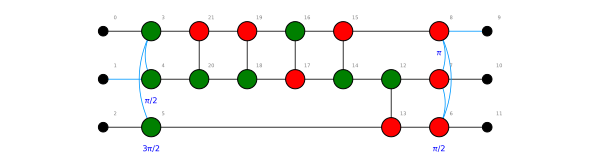

In [11]:
g2 = g.copy()
clifford_extract(g2,1,2)
#prepare(g2,1,2)
zx.draw(g2,labels=True)

In [12]:
t3 = zx.tensor.tensorfy(g2)
zx.tensor.compare_tensors(t2,t3)

True

In [8]:
prepare(g,1,2)
left_row = 1 
right_row = 2
qubits = g.qubit_count()
qleft = [v for v in g.vertices() if g.row(v)==left_row]
qright= [v for v in g.vertices() if g.row(v)==right_row]
m = bi_adj(g,qleft,qright)
x = zx.linalg.Mat2.id(3)
y = zx.linalg.Mat2.id(3)
#print(x)
print(m)
print("==")
m.gauss(full_reduce=True,x=x,y=y,blocksize=4)
print(x.inverse())

[ 0  1  0 ]
[ 1  0  1 ]
[ 1  0  0 ]
==
[ 0  1  0 ]
[ 1  0  1 ]
[ 1  0  0 ]


In [46]:
g = circ
v0 = 37
v1 = 55
types = g.types()
phases = g.phases()
v0t = types[v0]
v1t = types[v1]
v0a = phases[v0]
v1a = phases[v1]
print(v0t,v1t,v0a,v1a)
invalid_edge = False
v0n = set()
v0b = set()
for n in g.neighbours(v0):
    #if g.phase(n).denominator > 2:
    #    invalid_edge = True
    #    break
    et = g.edge_type(g.edge(v0,n))
    if n == v1 and et == 2: pass
    elif types[n] == 1 and et == 2: v0n.add(n)
    elif types[n] == 0: v0b.add(n)
    else:
        invalid_edge = True
        break
v0n, v0b

1 1 0 3/2


({9, 46}, set())

In [14]:
g = circ.copy()
#g.qubit_count()
#vert = min((v for v in g.vertices() if g.qubit(v)==1 and g.row(v)>2), key=g.row)
clifford_extract(g,1,2)
zx.draw(g,labels=True)

NameError: name 'bi_adj' is not defined

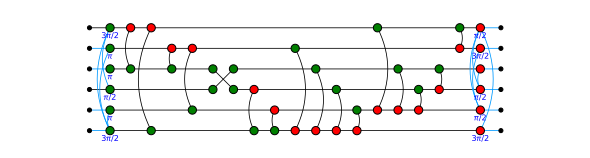

In [21]:
g2 = g.copy()
zx.simplify.clifford_simp(g2, quiet=True)
zx.drawing.pack_circuit_rows(g2)
clifford_extract(g2,1,2)
zx.draw(g2)

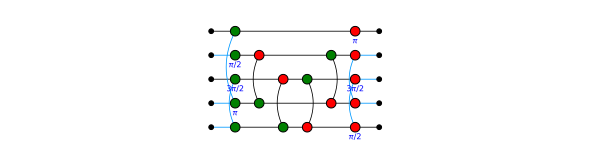

In [39]:
zx.draw(g)

In [5]:
from pyzx.extract import bi_adj
left = []
right = []
for v in circ.vertices():
    if circ.row(v) == 1:
        left.append(v)
    if circ.row(v) == 3:
        right.append(v)

left.sort(key=lambda v: circ.qubit(v))
right.sort(key=lambda v: circ.qubit(v))
#left = [5,6,7,8,9]
#right = [48,51,44,53,54]
qubits = len(left)
m = bi_adj(circ,left,right)
if m.rank() != qubits: print("Error!")
m

from pyzx.extract import CNOTMaker

c = CNOTMaker(qubits)
m.gauss(full_reduce=True,x=c)
c.finish()

[ 1  0  0  0  0 ]
[ 0  1  0  1  0 ]
[ 0  0  1  0  1 ]
[ 0  1  0  0  0 ]
[ 0  0  1  0  0 ]

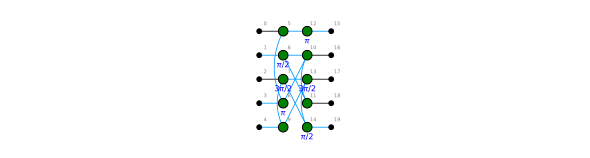

In [28]:
g = circ.copy()
zx.pack_circuit_rows(g)
zx.draw(g,labels=True)

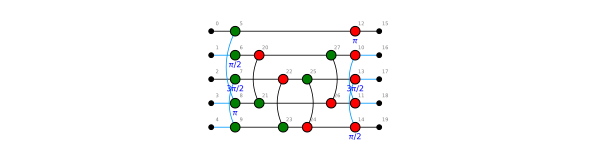

In [30]:
zx.draw(g,labels=True)

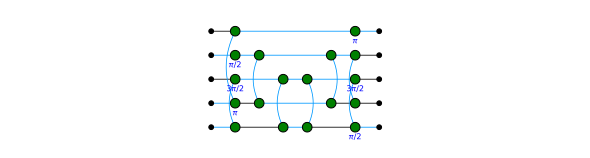

In [25]:
zx.to_gh(g)
zx.draw(g)

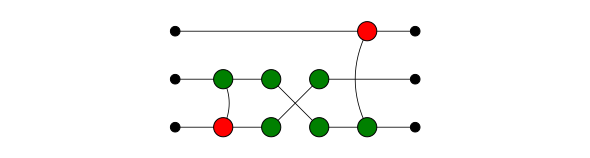

In [11]:
zx.draw(c.g.copy(adjoint=True))

spider_simp
1. 1. 
finished in 3 iterations
spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
id_simp

finished in 1 iterations


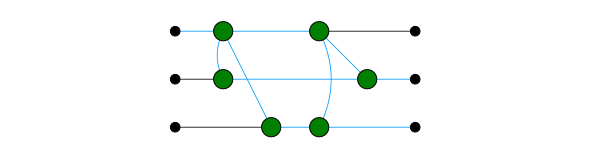

In [139]:
zx.clifford_simp(c.g)
zx.draw(c.g)

In [28]:
s = """
[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 1  0  0  1  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  1  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1  0 ]
[ 0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 ]"""
l = s.splitlines()[1:-1]
l = [[int(i) for i in j[1:-1].split(" ") if i] for j in l]
m = zx.linalg.Mat2(l)
print(m)

[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 1  0  0  1  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  1  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1  0 ]
[ 0  0  0  0  0  1  0  0  0  0  1  0  0 

In [30]:
zx.linalg.column_optimal_swap(m)

{0: 4,
 1: 7,
 2: 1,
 3: 6,
 4: 5,
 5: 16,
 6: 2,
 7: 3,
 8: 13,
 9: 9,
 10: 0,
 11: 8,
 12: 11,
 13: 14,
 14: 15,
 15: 17,
 16: 12,
 17: 10,
 18: 18}

In [21]:
qubits = 19
m = m.transpose()

connections = {i: set() for i in range(qubits)}
connectionsr= {j: set() for j in range(qubits)}

for i in range(qubits):
        for j in range(qubits):
            if m.data[i][j]: 
                connections[i].add(j)
                connectionsr[j].add(i)

def find_targets(conn, connr, target={}):
    target = target.copy()
    qubits = len(conn)
    claimedr = set(target.values())
    claimed = set(target.keys())
    
    while True: #First determine which qubit should go to which other qubit, before we start adding cnots.
        min_index = -1
        min_options = set(range(1000))
        for i in range(qubits):
            if i in claimed: continue
            s = conn[i] - claimedr
            for i2 in s.copy(): # Go trough the possible options
                for j1 in (connr[i2] - claimed): 
                    if j1 != i and j1 in target and i in connr[target[j1]]: # i connected to j2
                        #This is not allowed
                        print("not allowed1:", i, i2)
                        s.remove(i2)
            if len(s) == 0: return None # No possible options, start backtracking
            if len(s) == 1:
                j = s.pop()
                print("forced1", i,j)
                target[i] = j
                claimed.add(i)
                claimedr.add(j)
                break
            should_break = False
            for i2 in s:
                t = connr[i2] - claimed
                for i1 in t.copy():
                    for j1 in connr[i2]:
                        if j1 != i1 and j1 in target and i1 in connr[target[j1]]: 
                            print("not allowed2:", i1, j1)
                            t.remove(i1)
                if len(t) == 0: return None
                if len(t) == 1: # we must connect them together
                    i1 = t.pop()
                    print("forced2", i1,i2)
                    target[i1] = i2
                    claimed.add(i1)
                    claimedr.add(i2)
                    should_break = True
                    break
            if should_break: break
            if len(s) < len(min_options):
                min_index = i
                min_options = s
        else: # No forced decisions
            if not (conn.keys() - claimed): # we are done
                return target
            if min_index == -1: raise ValueError("This shouldn't happen ever")
            # Start depth-first search
            tgt = target.copy()
            print("backtracking on", min_index)
            for i2 in min_options:
                print("trying option", i2)
                tgt[min_index] = i2
                r = find_targets(conn, connr, tgt)
                if r: return r
            print("Unsuccessful")
            return target
            
            
            
                        
                
#         for v in unclaimed:
#             if v in connections[v]: # We can make a 'straight' connection, so do so
#                 print("straight", v)
#                 target[v] = v
#                 unclaimed.remove(v)
#                 break

target = find_targets(connections, connectionsr)
target

forced2 5 4
forced2 6 3
forced2 4 0
forced2 7 1
forced2 9 9
forced1 10 17
forced1 0 10
forced1 12 16
forced2 13 8
forced1 14 13
forced1 15 14
forced1 16 5
forced1 17 15
forced1 18 18
backtracking on 1
trying option 11
not allowed2: 8 1
not allowed2: 2 1
not allowed2: 3 1
trying option 12
not allowed2: 8 1
not allowed2: 2 1
not allowed2: 3 1
forced2 11 11
not allowed2: 8 11
not allowed2: 2 11
Unsuccessful


{0: 10,
 4: 0,
 5: 4,
 6: 3,
 7: 1,
 9: 9,
 10: 17,
 12: 16,
 13: 8,
 14: 13,
 15: 14,
 16: 5,
 17: 15,
 18: 18}

In [27]:
t = {v:k for k,v in target.items()}
leftover = set(range(qubits)).difference(t.values())
leftoverr = set(range(qubits)).difference(t.keys())
leftover, leftoverr

({1, 2, 3, 8, 11}, {2, 6, 7, 11, 12})

In [102]:
cnots = {i: set() for i in range(qubits)}

for i in range(qubits):
    for j in connections[i]:
        if target[i] == j: continue
        cnots[i].add(j)

for i, tgts in cnots.items():
    for j in tgts:
        #if j <= i: continue
        if i in cnots[j]: print("Conflict: ", i,j)

print(cnots)


Conflict:  0 0
Conflict:  1 1
Conflict:  4 4
{0: {0}, 1: {0, 1, 3}, 2: {0, 1}, 3: set(), 4: {3, 4}}


In [211]:
for i in range(1,101):
    if i%20 == 0: print(i, end='.')
    seed = random.randint(100,10000)
    random.seed(seed)
    circ = zx.generate.cliffordT(5, 200, p_t=0.2)
    g = circ.copy()
    zx.simplify.full_reduce(g)
    c = zx.extract.streaming_extract(g,quiet=True)
    if not zx.compare_tensors(c.to_tensor(),circ.to_tensor()):
        print(seed)
        raise Exception("bla")

20.40.60.80.100.

In [200]:
seed

5535

Greedy extract with 3 nodes and 5 CNOTs
12/40
Greedy extract with 1 nodes and 8 CNOTs
22/40
Greedy extract with 1 nodes and 4 CNOTs
32/40
Greedy cut failed
Complicated phase gadget
end
44/40
Greedy extract with 3 nodes and 7 CNOTs
53/40
Greedy extract with 4 nodes and 6 CNOTs
65/40
71/40


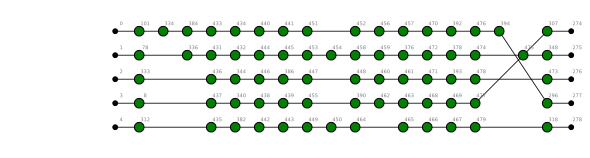

In [206]:
seed = 5535
random.seed(seed)
circ = zx.generate.cliffordT(5, 200, p_t=0.2)
g = circ.copy()
zx.simplify.full_reduce(g)
#zx.simplify.full_reduce(g,quiet=False)
c = zx.extract.streaming_extract(g,quiet=False)
#except (Exception, TypeError, ValueError): pass
#print(zx.compare_tensors(c.to_tensor(),circ.to_tensor()))
#zx.id_simp(g,quiet=True)
g.normalise()
zx.draw(g, labels=True)

In [172]:
zx.compare_tensors(circ.to_tensor(),c.to_tensor())

True

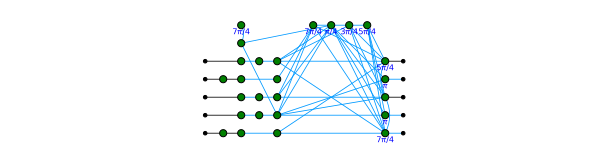

In [202]:
zx.draw(g)

In [142]:
c.gates

[HAD(0),
 ZPhase(0,phase=5/4),
 ZPhase(2,phase=3/2),
 HAD(2),
 ZPhase(2,phase=1/4),
 HAD(0),
 ZPhase(0,phase=7/4),
 CZ(2,1),
 HAD(1),
 ZPhase(1,phase=1/4),
 CZ(0,1),
 HAD(0),
 HAD(1),
 ZPhase(1,phase=5/4),
 CZ(2,1),
 HAD(1),
 CZ(2,1),
 HAD(2),
 HAD(1),
 HAD(2),
 SWAP(1,2)]

In [80]:
from pyzx.extract import cut_rank, bi_adj, cut_edges, unspider_by_row
from pyzx.linalg import column_optimal_swap
left = [151, 153, 155, 167]
right = {163, 108, 173, 166, 159}
candidates = {163, 108, 173, 166, 159}
q = len(left)
good_nodes = []
for w in candidates:
    if cut_rank(g, right.difference({w}), left) == q-1:
        good_nodes = [w]
        right = right.difference({w})
        candidates.remove(w)
        break
else:
    if not quiet: print("Greedy cut failed")
    #return [], False

while True:
    for w in candidates:
        if cut_rank(g, right.difference({w}), left) == q-len(good_nodes)-1:
            good_nodes.append(w)
            right = right.difference({w})
            candidates.remove(w)
            break
    else:
        break
new_right = cut_edges(g, left, list(right))
leftrow = g.row(left[0])
for w in good_nodes: 
    g.set_row(w, leftrow+2)
    new_right.append(unspider_by_row(g, w))

left.sort(key=g.qubit)
m = bi_adj(g, new_right, left)
target = column_optimal_swap(m)
for i, j in target.items():
    g.set_qubit(new_right[i],j)
new_right.sort(key=g.qubit)
m = bi_adj(g, new_right, left)
print(m)
gates = m.to_cnots(optimize=True)
gates
#zx.draw(g,labels=True,figsize=(20,4))

[ 1  1  0  1 ]
[ 0  1  0  0 ]
[ 1  1  1  0 ]
[ 0  0  0  1 ]


[CNOT(2,0), CNOT(2,3), CNOT(0,3), CNOT(0,1)]

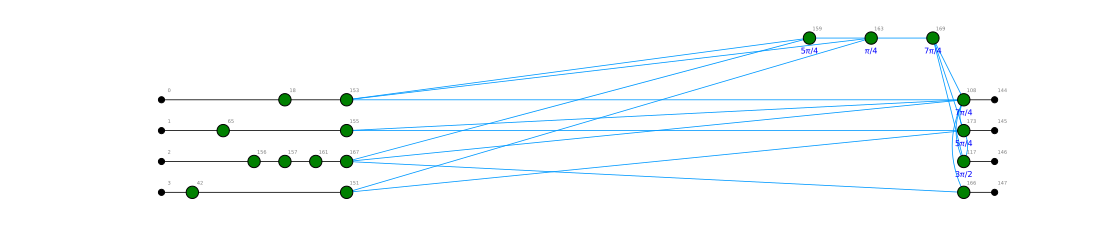

In [54]:
zx.draw(g,labels=True,figsize=(15,3))

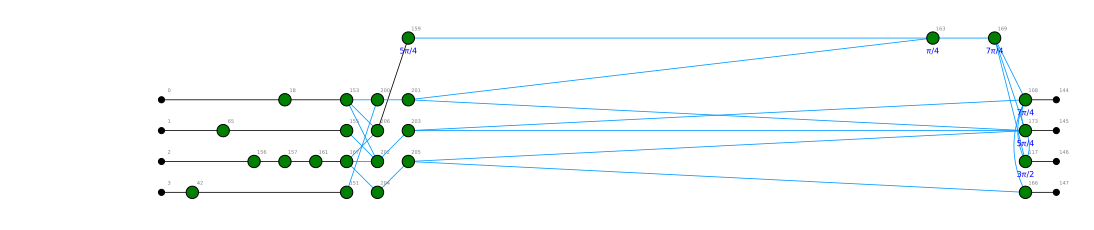

In [75]:
zx.draw(g,labels=True,figsize=(15,3))

In [35]:
g.qubit(516)

0

In [33]:
g = zx.Graph()
i1 = g.add_vertex(0,0,0)
i2 = g.add_vertex(0,1,0)
o1 = g.add_vertex(0,0,2)
o2 = g.add_vertex(0,1,2)
g.inputs = [i1, i2]
g.outputs = [o1, o2]
g2 = g.copy()
g.add_edges([(i1,o2),(i2,o1)])
g2.add_edges([(i1,o1),(i2,o2)])

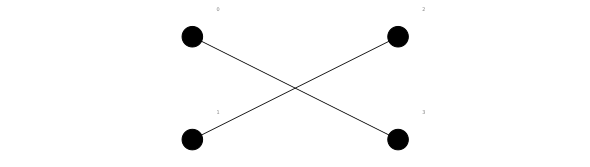

In [27]:
#g.normalise()
zx.draw(g,labels=True)

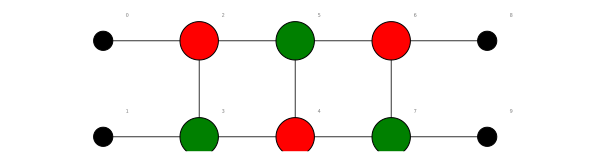

In [29]:
from pyzx.circuit import Circuit
c = Circuit(2)
c.add_gate("CNOT",0,1)
c.add_gate("CNOT",1,0)
c.add_gate("CNOT",0,1)
g2 = c.to_graph()
zx.draw(g2,labels=True)

In [30]:
zx.tensor.tensorfy(g)

array([[[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.]]],


       [[[0., 1.],
         [0., 0.]],

        [[0., 0.],
         [0., 1.]]]])

In [34]:
zx.tensor.tensorfy(g2)

array([[[[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]]]])

In [35]:
zx.tensor.compare_tensors(zx.tensor.tensorfy(g),zx.tensor.tensorfy(g2))

False